In [1]:
# || Header ||
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import fftpack
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
import ipyvolume as ipv
from skimage import measure
import linecache
import math
import random
import sys
sys.path.append('/home/andy/py_scripts/')
import sm_fxns as sm
import dimer_dissoc_analysis as lib
import plot_dimer_diss as plt_lib
import dimer_cavity as cav_lib
from importlib import reload
#%matplotlib inline
#plt.rcParams.update({'font.size': 14})
#plt.rcParams['figure.facecolor'] = 'white'

In [2]:
eVtokT = 1/(8.617333262145e-5 * 120)
unitl = 21.9166090280612
fkjmol = 189.100159648419

### Looking at energy gap fluctuations for Na2+ in Ar

In [3]:
def binDict(scalars, bond_dist, r0, r, dr):
    bins = np.arange(r0, r, dr)
    my_dict = {}
    for i in bins:
        my_dict[str(i+dr/2)] = []
    
    for i in range(len(scalars)):
        if bond_dist[i] < r0 or bond_dist[i] > r:
            continue
        else:
            my_ind = int((bond_dist[i]-r0)/dr)
            my_dict[str(np.round(r0+dr*my_ind+dr/2,2))] += [scalars[i]]
    
    return my_dict

In [4]:
def genDistr(my_array, spacing=0.1):
    low = int(min(my_array)/spacing)*spacing
    high = math.ceil(max(my_array)/spacing)*spacing
    bins = np.arange(low, high, spacing)
    counts = np.zeros([len(bins),3])
    
    for i in range(len(my_array)):
        counts[int((my_array[i]-low)/spacing),1] += 1
    norm = np.sum(counts[:,1])
    print(norm)
    counts[:,2] = np.sqrt((counts[:,1]/norm)*(1-counts[:,1]/norm)/norm)*1.96
    counts[:,1] /= norm
    counts[:,0] = bins + spacing/2
    
    return counts

In [5]:
def genFreeEnergy(pop_distr):
    e_distr = np.zeros([len(pop_distr),3])
    e_distr[:,0] = pop_distr[:,0]
    e_distr[:,1] = -np.log(pop_distr[:,1]/np.max(pop_distr[:,1]))/eVtokT
    my_ind = np.argwhere(pop_distr[:,1] == np.max(pop_distr[:,1]))[0][0]
    e_distr[:,2] = np.sqrt((pop_distr[:,2]/pop_distr[:,1])**2 + (pop_distr[my_ind,2]/pop_distr[my_ind,1])**2)/eVtokT
    return e_distr

#### Fluctutations at equilibrium as function of internuclear distance

In [6]:
# gas-phase eigvals as function of distance
gas_eigvals = np.zeros([len(np.loadtxt('/media/andy/Samsung_T5/supermic/analysis/Na2+_gas/SPE9_21Ang/bondumb2.out')[:,1]),6])
gas_eigvals[:,0] = np.loadtxt('/media/andy/Samsung_T5/supermic/analysis/Na2+_gas/SPE9_21Ang/bondumb2.out')[:,1]
for i in range(5):
    gas_eigvals[:,i+1] = np.loadtxt('/media/andy/Samsung_T5/supermic/analysis/Na2+_gas/SPE9_21Ang/out.quante'+str(i+1))[:,1]
gas_eigvals = gas_eigvals[gas_eigvals[:,0].argsort()]

In [ ]:
# loading bond distance and energy gap
# from umbrella sampling
r0 = 3; r = 9; dr = 0.2

root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/'
dirs = '3.1  3.7  3.8  4.2  4.4  4.8  5.0  5.1  5.3  5.5  5.6  5.7  6.0  6.1  6.3  6.4  6.5  \
        6.9  7.2  7.5  7.7  8.0  8.4  8.6  9.0  6.7  7.0  7.3  7.6  7.8  8.2  8.5  8.8'.split()
bond_dist_gnd = np.zeros(1)
e_gap_gnd = np.zeros(1)
for i in range(len(dirs)):
    my_dir = root+dirs[i]+'/'
    bond_dist_gnd = np.append(bond_dist_gnd, np.loadtxt(my_dir+'/bondumb1.out')[500:,1])
    eigvals = lib.readEigval(my_dir, nstates=5)[500:]
    e_gap_gnd = np.append(e_gap_gnd, eigvals[:,2] - eigvals[:,1])
bond_dist_gnd = np.delete(bond_dist_gnd, [0])
e_gap_gnd = np.delete(e_gap_gnd, [0])
e_gap_gnd = e_gap_gnd - np.interp(bond_dist_gnd, gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])

root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/fes/'
dirs = ['2.0', '2.3', '2.5', '2.8', '3.0', '3.3', '3.4', '3.8', '4.0', '4.2', '4.3', '4.4', '4.6', 
        '4.8', '5.0', '5.2', '5.4', '5.6', '5.8', '6.0', '6.1',
        '6.2', '6.4', '6.6', '6.8', '7.0', '7.2', '7.3', '7.4', '7.5',
        '7.6', '7.8', '8.0', '8.1', '8.3', '8.4', '8.5', '8.8', '8.9', '9.0']
bond_dist_fes = np.zeros(1)
e_gap_fes = np.zeros(1)
for i in range(len(dirs)):
    my_dir = root+dirs[i]+'/'
    bond_dist_fes = np.append(bond_dist_fes, np.loadtxt(my_dir+'/bondumb2.out')[500:,1])
    eigvals = lib.readEigval(my_dir, nstates=5)[500:]
    e_gap_fes = np.append(e_gap_fes, eigvals[:,2] - eigvals[:,1])
bond_dist_fes = np.delete(bond_dist_fes, [0])
e_gap_fes = np.delete(e_gap_fes, [0])
e_gap_fes = e_gap_fes - np.interp(bond_dist_fes, gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])

binned_gap_gnd = lib.binScalarsBondDist(e_gap_gnd, bond_dist_gnd, r0, r, dr)
binned_gap_fes = lib.binScalarsBondDist(e_gap_fes, bond_dist_fes, r0, r, dr)

gnd_dict = binDict(e_gap_gnd, bond_dist_gnd, r0, r, dr)
fes_dict = binDict(e_gap_fes, bond_dist_fes, r0, r, dr)

# from noneqb, dissociation traj
root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/first_es/fssh/'
dirs = '6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34'.split()
bond_dist_diss = np.zeros(1)
e_gap_diss = np.zeros(1)
for i in range(len(dirs)):
    my_dir = root+dirs[i]+'/1/'
    bond_dist_diss = np.append(bond_dist_diss, np.loadtxt(my_dir+'/bondumb2.out')[:190,1])
    eigvals = lib.readEigval(my_dir, nstates=2)[:190]
    e_gap_diss = np.append(e_gap_diss, eigvals[:,2] - eigvals[:,1])
bond_dist_diss = np.delete(bond_dist_diss, [0])
e_gap_diss = np.delete(e_gap_diss, [0])
e_gap_diss = e_gap_diss - np.interp(bond_dist_diss, gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])

binned_gap_diss = lib.binScalarsBondDist(e_gap_diss, bond_dist_diss, r0, r, dr)

diss_dict = binDict(e_gap_diss, bond_dist_diss, r0, r, dr)

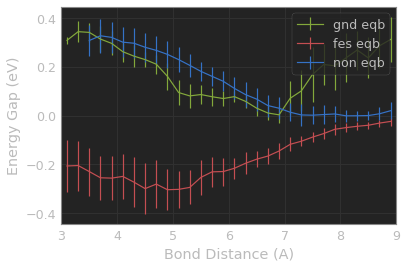

In [10]:
plt.errorbar(binned_gap_gnd[:,0], binned_gap_gnd[:,1], yerr=binned_gap_gnd[:,3], color='C1', label='gnd eqb')
plt.errorbar(binned_gap_fes[:,0], binned_gap_fes[:,1], yerr=binned_gap_fes[:,3], color='C2', label='fes eqb')
plt.errorbar(binned_gap_diss[:,0], binned_gap_diss[:,1], yerr=binned_gap_diss[:,3], color='C0', label='non eqb')
plt.xlim([3,9])
plt.xlabel('Bond Distance (A)')
plt.ylabel('Energy Gap (eV)')
plt.legend(loc=1)

798.0
1243.0
203.0


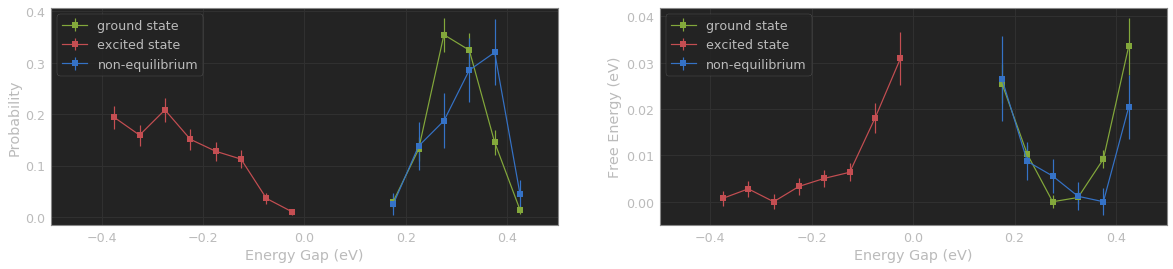

In [13]:
# centered at 3.8
a = '3.9'; s = 0.05
distr_gnd = genDistr(gnd_dict[a], spacing=s); e_gnd = genFreeEnergy(distr_gnd)
distr_fes = genDistr(fes_dict[a], spacing=s); e_fes = genFreeEnergy(distr_fes)
distr_diss = genDistr(diss_dict[a], spacing=s); e_diss = genFreeEnergy(distr_diss)
fig = plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
plt.errorbar(distr_gnd[:,0], distr_gnd[:,1], yerr=distr_gnd[:,2], color='C1', marker='s', label='ground state')
plt.errorbar(distr_fes[:,0], distr_fes[:,1], yerr=distr_fes[:,2], color='C2', marker='s', label='excited state')
plt.errorbar(distr_diss[:,0], distr_diss[:,1], yerr=distr_diss[:,2], color='C0', marker='s', label='non-equilibrium')
plt.xlim([-0.5,0.5])
plt.xlabel('Energy Gap (eV)')
plt.ylabel('Probability')
plt.legend(loc=2)
plt.subplot(1,2,2)
plt.errorbar(e_gnd[:,0], e_gnd[:,1], yerr=e_gnd[:,2], marker='s', color='C1', label='ground state')
plt.errorbar(e_fes[:,0], e_fes[:,1], yerr=e_fes[:,2], marker='s', color='C2', label='excited state')
plt.errorbar(e_diss[:,0], e_diss[:,1], yerr=e_diss[:,2], marker='s', color='C0', label='non-equilibrium')
plt.xlim([-0.5,0.5])
plt.xlabel('Energy Gap (eV)')
plt.ylabel('Free Energy (eV)')
plt.legend(loc=2)
#fig.savefig('energy gap potentials 38')

#### energy gap fluctuations against distance

In [13]:
def increasingBondDist(my_dir, tolerance = 0.1, r_stop = 9.0):
    bond_dist = np.loadtxt(my_dir+'/bondumb2.out')

    loc_max = bond_dist[0,1]
    my_ind = 0
    for i in range(1,len(bond_dist)):
        if bond_dist[i,1] > loc_max and bond_dist[i,1] < r_stop:
            loc_max = bond_dist[i,1]
            my_ind = i
        elif loc_max - bond_dist[i,1] > tolerance or bond_dist[i,1] > r_stop:
            break

    return bond_dist[:my_ind]

In [15]:
# ground-state eigvals as function of distance
root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/'
dirs = '3.1  3.7  3.8  4.2  4.4  4.8  5.0  5.1  5.3  5.5  5.6  5.7  6.0  6.1  6.3  6.4  6.5  \
        6.9  7.2  7.5  7.7  8.0  8.4  8.6  9.0  6.7  7.0  7.3  7.6  7.8  8.2  8.5  8.8'.split()

my_dir = root+dirs[0]
dists = np.loadtxt(my_dir+'/bondumb2.out')[500:,1]
eigvals = lib.readEigval(my_dir, nstates=5)[500:]

for i in range(1,len(dirs)):
    my_dir = root+dirs[i]
    dists = np.append(dists, np.loadtxt(my_dir+'/bondumb2.out')[500:,1])
    eigvals = np.append(eigvals, lib.readEigval(my_dir, nstates=5)[500:], axis=0)

eigvals_gnd = np.array([dists, eigvals[:,1], eigvals[:,2]]).T
eigvals_gnd = eigvals_gnd[eigvals_gnd[:,0].argsort()]

In [16]:
# excited-state eigvals as function of distance
root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/fes/'
dirs = ['2.0', '2.3', '2.5', '2.8', '3.0', '3.3', '3.4', '3.8', '4.0', '4.2', '4.3', '4.4', '4.6', 
        '4.8', '5.0', '5.2', '5.4', '5.6', '5.8', '6.0', '6.1', '6.2', '6.4', '6.6', '6.8', '7.0', 
        '7.2', '7.3', '7.4', '7.5', '7.6', '7.8', '8.0', '8.1', '8.3', '8.4', '8.5', '8.8', '8.9', '9.0']

my_dir = root+dirs[0]
dists = np.loadtxt(my_dir+'/bondumb2.out')[500:,1]
eigvals = lib.readEigval(my_dir, nstates=5)[500:]

for i in range(1,len(dirs)):
    my_dir = root+dirs[i]
    dists = np.append(dists, np.loadtxt(my_dir+'/bondumb2.out')[500:,1])
    eigvals = np.append(eigvals, lib.readEigval(my_dir, nstates=5)[500:], axis=0)

eigvals_fes = np.array([dists, eigvals[:,1], eigvals[:,2]]).T
eigvals_fes = eigvals_fes[eigvals_fes[:,0].argsort()]

In [17]:
# gas-phase eigvals as function of distance
gas_eigvals = np.zeros([len(np.loadtxt('/media/andy/Samsung_T5/supermic/analysis/Na2+_gas/SPE9_21Ang/bondumb2.out')[:,1]),6])
gas_eigvals[:,0] = np.loadtxt('/media/andy/Samsung_T5/supermic/analysis/Na2+_gas/SPE9_21Ang/bondumb2.out')[:,1]
for i in range(5):
    gas_eigvals[:,i+1] = np.loadtxt('/media/andy/Samsung_T5/supermic/analysis/Na2+_gas/SPE9_21Ang/out.quante'+str(i+1))[:,1]
gas_eigvals = gas_eigvals[gas_eigvals[:,0].argsort()]

In [13]:
# normal mass eigvals as function of distance
root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/first_es/fssh/'
dirs = np.arange(1,101)

my_dir = root+str(dirs[0])+'/1/'
dists = increasingBondDist(my_dir)[:,1]
eigvals = lib.readEigval(my_dir, nstates=2)[:len(dists)]

for i in range(1,len(dirs)):
    my_dir = root+str(dirs[i])+'/1/'
    my_dist = increasingBondDist(my_dir)[:,1]
    dists = np.append(dists, my_dist, axis=0)
    eigvals = np.append(eigvals, lib.readEigval(my_dir, nstates=2)[:len(my_dist)], axis=0)

eigvals_diss = np.array([dists, eigvals[:,1], eigvals[:,2]]).T
eigvals_diss = eigvals_diss[eigvals_diss[:,0].argsort()]

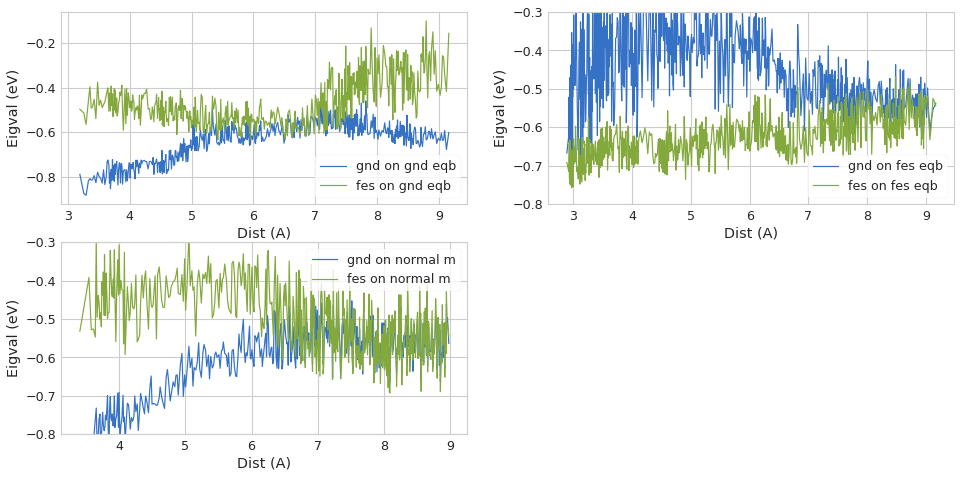

In [21]:
# Looking at evolution of eigvals for particular trajectory
plt.figure(figsize=(16,12))
plt.subplot(3,2,1)
plt.plot(eigvals_gnd[::50,0], eigvals_gnd[::50,1]-np.interp(eigvals_gnd[::50,0], gas_eigvals[:,0], gas_eigvals[:,1]), label='gnd on gnd eqb')
plt.plot(eigvals_gnd[::50,0], eigvals_gnd[::50,2]-np.interp(eigvals_gnd[::50,0], gas_eigvals[:,0], gas_eigvals[:,2]), label='fes on gnd eqb')
#plt.ylim([-0.8,-0.3])
plt.xlabel('Dist (A)')
plt.ylabel('Eigval (eV)')
plt.legend(loc=4)
plt.subplot(3,2,2)
plt.plot(eigvals_fes[::50,0], eigvals_fes[::50,1]-np.interp(eigvals_fes[::50,0], gas_eigvals[:,0], gas_eigvals[:,1]), label='gnd on fes eqb')
plt.plot(eigvals_fes[::50,0], eigvals_fes[::50,2]-np.interp(eigvals_fes[::50,0], gas_eigvals[:,0], gas_eigvals[:,2]), label='fes on fes eqb')
plt.ylim([-0.8,-0.3])
plt.xlabel('Dist (A)')
plt.ylabel('Eigval (eV)')
plt.legend(loc=4)
plt.subplot(3,2,3)
plt.plot(eigvals_diss[::20,0], eigvals_diss[::20,1]-np.interp(eigvals_diss[::20,0], gas_eigvals[:,0], gas_eigvals[:,1]), label='gnd on normal m')
plt.plot(eigvals_diss[::20,0], eigvals_diss[::20,2]-np.interp(eigvals_diss[::20,0], gas_eigvals[:,0], gas_eigvals[:,2]), label='fes on normal m')
plt.ylim([-0.8,-0.3])
plt.xlabel('Dist (A)')
plt.ylabel('Eigval (eV)')
plt.legend(loc=1)

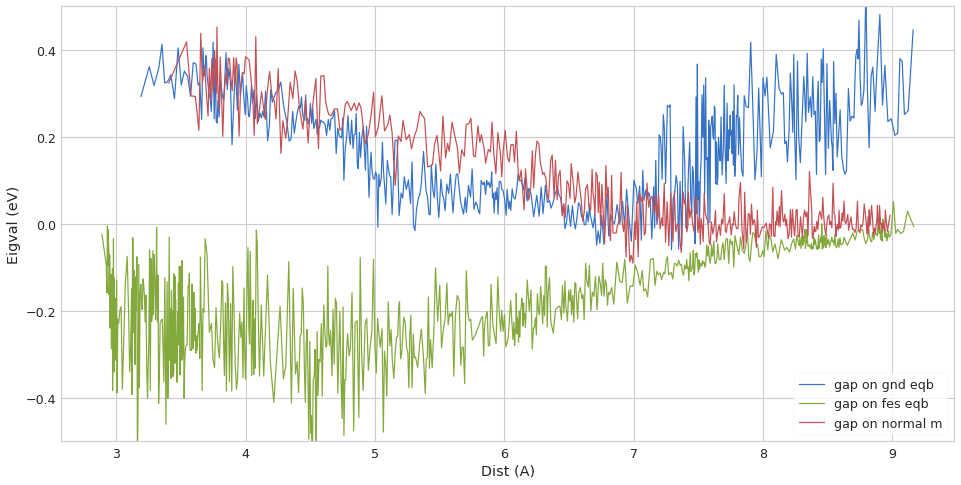

In [19]:
# egap as fxn of bond dist. Plotting many points to get sense of noise
plt.figure(figsize=(16,8))
plt.plot(eigvals_gnd[::50,0], eigvals_gnd[::50,2]-eigvals_gnd[::50,1]-np.interp(eigvals_gnd[::50,0], gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1]), label='gap on gnd eqb')
plt.plot(eigvals_fes[::50,0], eigvals_fes[::50,2]-eigvals_fes[::50,1]-np.interp(eigvals_fes[::50,0], gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1]), label='gap on fes eqb')
plt.plot(eigvals_diss[::20,0], eigvals_diss[::20,2]-eigvals_diss[::20,1]-np.interp(eigvals_diss[::20,0], gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1]), label='gap on normal m', color='C2')
plt.ylim([-0.5,0.5])
plt.xlabel('Dist (A)')
plt.ylabel('Eigval (eV)')
plt.legend(loc=4)

### Looking at autocorrelation of energy gap

#### For Ar

In [10]:
# S(t) with adjusted energy gap
a = 0

root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/first_es/fssh/'
dirs = np.arange(1,101)

gaps = np.zeros([500-a,len(dirs)+1])
dists = np.zeros([500-a,len(dirs)+1])
adj_gaps = np.zeros([500-a,len(dirs)+1])
gap = np.zeros([500-a,3])

for i in range(len(dirs)):
    my_dir = root+str(dirs[i])+'/1/'
    eigvals = lib.readEigval(my_dir, nstates=2)[a:500]
    gaps[:,i+1] = eigvals[:,2] - eigvals[:,1]
    dists[:,i+1] = np.loadtxt(my_dir+'/bondumb2.out')[a:500,1]
gaps[:,0] = eigvals[:,0]

for i in range(len(dirs)):
    adj_gaps[:,i+1] = gaps[:,i+1] - np.interp(dists[:,i+1], gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])
adj_gaps[:,0] = gaps[:,0]

gap[:,0] = adj_gaps[:,0]
gap[:,1] = np.average(adj_gaps[:,1:], axis=1)
gap[:,2] = stats.sem(adj_gaps[:,1:], axis=1)

S_t = np.zeros([len(gap),3])
S_t[:,0] = gap[:,0]
S_t[:,1] = (gap[:,1] - 0.0)/(gap[0,1] - 0.0)
S_t[:,2] = (gap[:,1]-0.0)/(gap[0,1]-0.0)*\
            np.sqrt((gap[:,2]**2+gap[-1,2]**2)/(gap[:,1]-0.0)**2 + (gap[0,2]**2+gap[-1,2]**2)/(gap[0,1]+0.0)**2)
# S_t[:,1] = (gap[:,1] - gap[-1,1])/(gap[0,1] - gap[-1,1])
# S_t[:,2] = (gap[:,1]-gap[-1,1])/(gap[0,1]-gap[-1,1])*\
#             np.sqrt((gap[:,2]**2+gap[-1,2]**2)/(gap[:,1]-gap[-1,1])**2 + (gap[0,2]**2+gap[-1,2]**2)/(gap[0,1]+gap[-1,1])**2)

In [11]:
# Calculating C(t) at [3.8, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0] Ang with rigid bond on gnd eqb
a = '3.8'
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/rigid/'+a+'/'
eigvals_gnd = lib.readEigval(my_dir, nstates=2)[500:]
bond_dist_gnd = np.loadtxt(my_dir+'/bondumb2.out')[500:]
gap_gnd = eigvals_gnd[:,2] - eigvals_gnd[:,1] - np.interp(bond_dist_gnd[:,1], gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])
gap_gnd -= np.average(gap_gnd)

gnd38 = np.zeros([len(eigvals_gnd),3])
gnd38[:,0] = eigvals_gnd[:,0] - eigvals_gnd[0,0]
my_dict = {}
for i in range(len(gnd38)):
    my_dict[str(gnd38[i,0])] = []
for i in range(len(gap_gnd)):
    for j in range(i,len(gap_gnd)):
        my_dict[str(4.0*(j-i))] += [gap_gnd[i]*gap_gnd[j]]
my_norm = np.average(gap_gnd*gap_gnd)
for i in range(len(gap_gnd)):
    gnd38[i,1] = np.average(my_dict[str(4.0*i)])/my_norm
    gnd38[i,2] = np.std(my_dict[str(4.0*i)]/my_norm)/np.sqrt(len(gap_gnd)-i)

print('avg bond dist gnd = '+str(np.average(bond_dist_gnd[:,1]))+'; std gnd = '+str(np.std(bond_dist_gnd[:,1])))

a = '4.0'
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/rigid/'+a+'/'
eigvals_gnd = lib.readEigval(my_dir, nstates=2)[500:]
bond_dist_gnd = np.loadtxt(my_dir+'/bondumb2.out')[500:]
gap_gnd = eigvals_gnd[:,2] - eigvals_gnd[:,1] - np.interp(bond_dist_gnd[:,1], gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])
gap_gnd -= np.average(gap_gnd)
#gap_gnd = eigvals_gnd[:,2] - eigvals_gnd[:,1] - np.average(eigvals_gnd[:,2] - eigvals_gnd[:,1])

gnd40 = np.zeros([len(eigvals_gnd),3])
gnd40[:,0] = eigvals_gnd[:,0] - eigvals_gnd[0,0]
my_dict = {}
for i in range(len(gnd40)):
    my_dict[str(gnd40[i,0])] = []
for i in range(len(gap_gnd)):
    for j in range(i,len(gap_gnd)):
        my_dict[str(4.0*(j-i))] += [gap_gnd[i]*gap_gnd[j]]
my_norm = np.average(gap_gnd*gap_gnd)
for i in range(len(gap_gnd)):
#    gnd40[i,1] = np.average(my_dict[str(4.0*i)])/(gap_gnd[i]**2)
    gnd40[i,1] = np.average(my_dict[str(4.0*i)])/my_norm
    gnd40[i,2] = np.std(my_dict[str(4.0*i)]/my_norm)/np.sqrt(len(gap_gnd)-i)

print('avg bond dist gnd = '+str(np.average(bond_dist_gnd[:,1]))+'; std gnd = '+str(np.std(bond_dist_gnd[:,1])))

a = '4.5'
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/rigid/'+a+'/'
eigvals_gnd = lib.readEigval(my_dir, nstates=2)[500:]
bond_dist_gnd = np.loadtxt(my_dir+'/bondumb2.out')[500:]
gap_gnd = eigvals_gnd[:,2] - eigvals_gnd[:,1] - np.interp(bond_dist_gnd[:,1], gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])
gap_gnd -= np.average(gap_gnd)
#gap_gnd = eigvals_gnd[:,2] - eigvals_gnd[:,1] - np.average(eigvals_gnd[:,2] - eigvals_gnd[:,1])

gnd45 = np.zeros([len(eigvals_gnd),3])
gnd45[:,0] = eigvals_gnd[:,0] - eigvals_gnd[0,0]
my_dict = {}
for i in range(len(gnd45)):
    my_dict[str(gnd45[i,0])] = []
for i in range(len(gap_gnd)):
    for j in range(i,len(gap_gnd)):
        my_dict[str(4.0*(j-i))] += [gap_gnd[i]*gap_gnd[j]]
my_norm = np.average(gap_gnd*gap_gnd)
for i in range(len(gap_gnd)):
#    gnd45[i,1] = np.average(my_dict[str(4.0*i)])/(gap_gnd[i]**2)
    gnd45[i,1] = np.average(my_dict[str(4.0*i)])/my_norm
    gnd45[i,2] = np.std(my_dict[str(4.0*i)]/my_norm)/np.sqrt(len(gap_gnd)-i)

print('avg bond dist gnd = '+str(np.average(bond_dist_gnd[:,1]))+'; std gnd = '+str(np.std(bond_dist_gnd[:,1])))

a = '5.0'
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/rigid/'+a+'/'
eigvals_gnd = lib.readEigval(my_dir, nstates=2)[500:]
bond_dist_gnd = np.loadtxt(my_dir+'/bondumb2.out')[500:]
gap_gnd = eigvals_gnd[:,2] - eigvals_gnd[:,1] - np.interp(bond_dist_gnd[:,1], gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])
gap_gnd -= np.average(gap_gnd)
#gap_gnd = eigvals_gnd[:,2] - eigvals_gnd[:,1] - np.average(eigvals_gnd[:,2] - eigvals_gnd[:,1])

gnd50 = np.zeros([len(eigvals_gnd),3])
gnd50[:,0] = eigvals_gnd[:,0] - eigvals_gnd[0,0]
my_dict = {}
for i in range(len(gnd50)):
    my_dict[str(gnd50[i,0])] = []
for i in range(len(gap_gnd)):
    for j in range(i,len(gap_gnd)):
        my_dict[str(4.0*(j-i))] += [gap_gnd[i]*gap_gnd[j]]
my_norm = np.average(gap_gnd*gap_gnd)
for i in range(len(gap_gnd)):
#    gnd50[i,1] = np.average(my_dict[str(4.0*i)])/(gap_gnd[i]**2)
    gnd50[i,1] = np.average(my_dict[str(4.0*i)])/my_norm
    gnd50[i,2] = np.std(my_dict[str(4.0*i)]/my_norm)/np.sqrt(len(gap_gnd)-i)

print('avg bond dist gnd = '+str(np.average(bond_dist_gnd[:,1]))+'; std gnd = '+str(np.std(bond_dist_gnd[:,1])))

a = '5.5'
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/rigid/'+a+'/'
eigvals_gnd = lib.readEigval(my_dir, nstates=2)[500:]
bond_dist_gnd = np.loadtxt(my_dir+'/bondumb2.out')[500:]
gap_gnd = eigvals_gnd[:,2] - eigvals_gnd[:,1] - np.interp(bond_dist_gnd[:,1], gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])
gap_gnd -= np.average(gap_gnd)
#gap_gnd = eigvals_gnd[:,2] - eigvals_gnd[:,1] - np.average(eigvals_gnd[:,2] - eigvals_gnd[:,1])

gnd55 = np.zeros([len(eigvals_gnd),3])
gnd55[:,0] = eigvals_gnd[:,0] - eigvals_gnd[0,0]
my_dict = {}
for i in range(len(gnd55)):
    my_dict[str(gnd55[i,0])] = []
for i in range(len(gap_gnd)):
    for j in range(i,len(gap_gnd)):
        my_dict[str(4.0*(j-i))] += [gap_gnd[i]*gap_gnd[j]]
my_norm = np.average(gap_gnd*gap_gnd)
for i in range(len(gap_gnd)):
#    gnd55[i,1] = np.average(my_dict[str(4.0*i)])/(gap_gnd[i]**2)
    gnd55[i,1] = np.average(my_dict[str(4.0*i)])/my_norm
    gnd55[i,2] = np.std(my_dict[str(4.0*i)]/my_norm)/np.sqrt(len(gap_gnd)-i)

print('avg bond dist gnd = '+str(np.average(bond_dist_gnd[:,1]))+'; std gnd = '+str(np.std(bond_dist_gnd[:,1])))

a = '6.0'
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/rigid/'+a+'/'
eigvals_gnd = lib.readEigval(my_dir, nstates=2)[500:]
bond_dist_gnd = np.loadtxt(my_dir+'/bondumb2.out')[500:]
gap_gnd = eigvals_gnd[:,2] - eigvals_gnd[:,1] - np.interp(bond_dist_gnd[:,1], gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])
gap_gnd -= np.average(gap_gnd)
#gap_gnd = eigvals_gnd[:,2] - eigvals_gnd[:,1] - np.average(eigvals_gnd[:,2] - eigvals_gnd[:,1])

gnd60 = np.zeros([len(eigvals_gnd),3])
gnd60[:,0] = eigvals_gnd[:,0] - eigvals_gnd[0,0]
my_dict = {}
for i in range(len(gnd60)):
    my_dict[str(gnd60[i,0])] = []
for i in range(len(gap_gnd)):
    for j in range(i,len(gap_gnd)):
        my_dict[str(4.0*(j-i))] += [gap_gnd[i]*gap_gnd[j]]
my_norm = np.average(gap_gnd*gap_gnd)
for i in range(len(gap_gnd)):
#    gnd60[i,1] = np.average(my_dict[str(4.0*i)])/(gap_gnd[i]**2)
    gnd60[i,1] = np.average(my_dict[str(4.0*i)])/my_norm
    gnd60[i,2] = np.std(my_dict[str(4.0*i)]/my_norm)/np.sqrt(len(gap_gnd)-i)

print('avg bond dist gnd = '+str(np.average(bond_dist_gnd[:,1]))+'; std gnd = '+str(np.std(bond_dist_gnd[:,1])))

a = '6.5'
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/rigid/'+a+'/'
eigvals_gnd = lib.readEigval(my_dir, nstates=2)[500:]
bond_dist_gnd = np.loadtxt(my_dir+'/bondumb2.out')[500:]
gap_gnd = eigvals_gnd[:,2] - eigvals_gnd[:,1] - np.interp(bond_dist_gnd[:,1], gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])
gap_gnd -= np.average(gap_gnd)
#gap_gnd = eigvals_gnd[:,2] - eigvals_gnd[:,1] - np.average(eigvals_gnd[:,2] - eigvals_gnd[:,1])

gnd65 = np.zeros([len(eigvals_gnd),3])
gnd65[:,0] = eigvals_gnd[:,0] - eigvals_gnd[0,0]
my_dict = {}
for i in range(len(gnd65)):
    my_dict[str(gnd65[i,0])] = []
for i in range(len(gap_gnd)):
    for j in range(i,len(gap_gnd)):
        my_dict[str(4.0*(j-i))] += [gap_gnd[i]*gap_gnd[j]]
my_norm = np.average(gap_gnd*gap_gnd)
for i in range(len(gap_gnd)):
#    gnd65[i,1] = np.average(my_dict[str(4.0*i)])/(gap_gnd[i]**2)
    gnd65[i,1] = np.average(my_dict[str(4.0*i)])/my_norm
    gnd65[i,2] = np.std(my_dict[str(4.0*i)]/my_norm)/np.sqrt(len(gap_gnd)-i)

print('avg bond dist gnd = '+str(np.average(bond_dist_gnd[:,1]))+'; std gnd = '+str(np.std(bond_dist_gnd[:,1])))

a = '7.0'
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/rigid/'+a+'/'
eigvals_gnd = lib.readEigval(my_dir, nstates=2)[500:]
bond_dist_gnd = np.loadtxt(my_dir+'/bondumb2.out')[500:]
gap_gnd = eigvals_gnd[:,2] - eigvals_gnd[:,1] - np.interp(bond_dist_gnd[:,1], gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])
gap_gnd -= np.average(gap_gnd)
#gap_gnd = eigvals_gnd[:,2] - eigvals_gnd[:,1] - np.average(eigvals_gnd[:,2] - eigvals_gnd[:,1])

gnd70 = np.zeros([len(eigvals_gnd),3])
gnd70[:,0] = eigvals_gnd[:,0] - eigvals_gnd[0,0]
my_dict = {}
for i in range(len(gnd70)):
    my_dict[str(gnd70[i,0])] = []
for i in range(len(gap_gnd)):
    for j in range(i,len(gap_gnd)):
        my_dict[str(4.0*(j-i))] += [gap_gnd[i]*gap_gnd[j]]
my_norm = np.average(gap_gnd*gap_gnd)
for i in range(len(gap_gnd)):
#    gnd70[i,1] = np.average(my_dict[str(4.0*i)])/(gap_gnd[i]**2)
    gnd70[i,1] = np.average(my_dict[str(4.0*i)])/my_norm
    gnd70[i,2] = np.std(my_dict[str(4.0*i)]/my_norm)/np.sqrt(len(gap_gnd)-i)

print('avg bond dist gnd = '+str(np.average(bond_dist_gnd[:,1]))+'; std gnd = '+str(np.std(bond_dist_gnd[:,1])))

a = '7.5'
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/rigid/'+a+'/'
eigvals_gnd = lib.readEigval(my_dir, nstates=2)[500:]
bond_dist_gnd = np.loadtxt(my_dir+'/bondumb2.out')[500:]
gap_gnd = eigvals_gnd[:,2] - eigvals_gnd[:,1] - np.interp(bond_dist_gnd[:,1], gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])
gap_gnd -= np.average(gap_gnd)
#gap_gnd = eigvals_gnd[:,2] - eigvals_gnd[:,1] - np.average(eigvals_gnd[:,2] - eigvals_gnd[:,1])

gnd75 = np.zeros([len(eigvals_gnd),3])
gnd75[:,0] = eigvals_gnd[:,0] - eigvals_gnd[0,0]
my_dict = {}
for i in range(len(gnd75)):
    my_dict[str(gnd75[i,0])] = []
for i in range(len(gap_gnd)):
    for j in range(i,len(gap_gnd)):
        my_dict[str(4.0*(j-i))] += [gap_gnd[i]*gap_gnd[j]]
my_norm = np.average(gap_gnd*gap_gnd)
for i in range(len(gap_gnd)):
#    gnd75[i,1] = np.average(my_dict[str(4.0*i)])/(gap_gnd[i]**2)
    gnd75[i,1] = np.average(my_dict[str(4.0*i)])/my_norm
    gnd75[i,2] = np.std(my_dict[str(4.0*i)]/my_norm)/np.sqrt(len(gap_gnd)-i)

print('avg bond dist gnd = '+str(np.average(bond_dist_gnd[:,1]))+'; std gnd = '+str(np.std(bond_dist_gnd[:,1])))

a = '8.0'
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/rigid/'+a+'/'
eigvals_gnd = lib.readEigval(my_dir, nstates=2)[500:]
bond_dist_gnd = np.loadtxt(my_dir+'/bondumb2.out')[500:]
gap_gnd = eigvals_gnd[:,2] - eigvals_gnd[:,1] - np.interp(bond_dist_gnd[:,1], gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])
gap_gnd -= np.average(gap_gnd)
#gap_gnd = eigvals_gnd[:,2] - eigvals_gnd[:,1] - np.average(eigvals_gnd[:,2] - eigvals_gnd[:,1])

gnd80 = np.zeros([len(eigvals_gnd),3])
gnd80[:,0] = eigvals_gnd[:,0] - eigvals_gnd[0,0]
my_dict = {}
for i in range(len(gnd80)):
    my_dict[str(gnd80[i,0])] = []
for i in range(len(gap_gnd)):
    for j in range(i,len(gap_gnd)):
        my_dict[str(4.0*(j-i))] += [gap_gnd[i]*gap_gnd[j]]
my_norm = np.average(gap_gnd*gap_gnd)
for i in range(len(gap_gnd)):
#    gnd80[i,1] = np.average(my_dict[str(4.0*i)])/(gap_gnd[i]**2)
    gnd80[i,1] = np.average(my_dict[str(4.0*i)])/my_norm
    gnd80[i,2] = np.std(my_dict[str(4.0*i)]/my_norm)/np.sqrt(len(gap_gnd)-i)

print('avg bond dist gnd = '+str(np.average(bond_dist_gnd[:,1]))+'; std gnd = '+str(np.std(bond_dist_gnd[:,1])))

a = '8.5'
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/rigid/'+a+'/'
eigvals_gnd = lib.readEigval(my_dir, nstates=2)[500:]
bond_dist_gnd = np.loadtxt(my_dir+'/bondumb2.out')[500:]
gap_gnd = eigvals_gnd[:,2] - eigvals_gnd[:,1] - np.interp(bond_dist_gnd[:,1], gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])
gap_gnd -= np.average(gap_gnd)
#gap_gnd = eigvals_gnd[:,2] - eigvals_gnd[:,1] - np.average(eigvals_gnd[:,2] - eigvals_gnd[:,1])

gnd85 = np.zeros([len(eigvals_gnd),3])
gnd85[:,0] = eigvals_gnd[:,0] - eigvals_gnd[0,0]
my_dict = {}
for i in range(len(gnd85)):
    my_dict[str(gnd85[i,0])] = []
for i in range(len(gap_gnd)):
    for j in range(i,len(gap_gnd)):
        my_dict[str(4.0*(j-i))] += [gap_gnd[i]*gap_gnd[j]]
my_norm = np.average(gap_gnd*gap_gnd)
for i in range(len(gap_gnd)):
#    gnd85[i,1] = np.average(my_dict[str(4.0*i)])/(gap_gnd[i]**2)
    gnd85[i,1] = np.average(my_dict[str(4.0*i)])/my_norm
    gnd85[i,2] = np.std(my_dict[str(4.0*i)]/my_norm)/np.sqrt(len(gap_gnd)-i)

print('avg bond dist gnd = '+str(np.average(bond_dist_gnd[:,1]))+'; std gnd = '+str(np.std(bond_dist_gnd[:,1])))

a = '9.0'
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/rigid/'+a+'/'
eigvals_gnd = lib.readEigval(my_dir, nstates=2)[500:]
bond_dist_gnd = np.loadtxt(my_dir+'/bondumb2.out')[500:]
gap_gnd = eigvals_gnd[:,2] - eigvals_gnd[:,1] - np.interp(bond_dist_gnd[:,1], gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])
gap_gnd -= np.average(gap_gnd)
#gap_gnd = eigvals_gnd[:,2] - eigvals_gnd[:,1] - np.average(eigvals_gnd[:,2] - eigvals_gnd[:,1])

gnd90 = np.zeros([len(eigvals_gnd),3])
gnd90[:,0] = eigvals_gnd[:,0] - eigvals_gnd[0,0]
my_dict = {}
for i in range(len(gnd90)):
    my_dict[str(gnd90[i,0])] = []
for i in range(len(gap_gnd)):
    for j in range(i,len(gap_gnd)):
        my_dict[str(4.0*(j-i))] += [gap_gnd[i]*gap_gnd[j]]
my_norm = np.average(gap_gnd*gap_gnd)
for i in range(len(gap_gnd)):
#    gnd90[i,1] = np.average(my_dict[str(4.0*i)])/(gap_gnd[i]**2)
    gnd90[i,1] = np.average(my_dict[str(4.0*i)])/my_norm
    gnd90[i,2] = np.std(my_dict[str(4.0*i)]/my_norm)/np.sqrt(len(gap_gnd)-i)

print('avg bond dist gnd = '+str(np.average(bond_dist_gnd[:,1]))+'; std gnd = '+str(np.std(bond_dist_gnd[:,1])))

avg bond dist gnd = 3.8085619534853006; std gnd = 4.440892098500626e-16
avg bond dist gnd = 3.9838666443157695; std gnd = 4.440892098500626e-16
avg bond dist gnd = 4.501387370793261; std gnd = 8.881784197001252e-16
avg bond dist gnd = 4.9981372086744; std gnd = 0.0
avg bond dist gnd = 5.49101259762709; std gnd = 0.0
avg bond dist gnd = 5.973004102496281; std gnd = 8.881784197001252e-16
avg bond dist gnd = 6.51818334933292; std gnd = 0.0
avg bond dist gnd = 6.988901424997449; std gnd = 8.881784197001252e-16
avg bond dist gnd = 7.51675582187209; std gnd = 0.0
avg bond dist gnd = 8.001495010349712; std gnd = 1.7763568394002505e-15
avg bond dist gnd = 8.497930352465207; std gnd = 1.7763568394002505e-15
avg bond dist gnd = 8.936982380653742; std gnd = 1.7763568394002505e-15


In [53]:
# Calculating C(t) at [3.8, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0] Ang with rigid bond on fes eqb
a = '3.8'
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/fes/rigid/'+a+'/'
eigvals_fes = lib.readEigval(my_dir, nstates=2)[500:]
bond_dist_fes = np.loadtxt(my_dir+'/bondumb2.out')[500:]
gap_fes = eigvals_fes[:,2] - eigvals_fes[:,1] - np.interp(bond_dist_fes[:,1], gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])
gap_fes -= np.average(gap_fes)
#gap_fes = eigvals_fes[:,2] - eigvals_fes[:,1] - np.average(eigvals_fes[:,2] - eigvals_fes[:,1])

fes38 = np.zeros([len(eigvals_fes),3])
fes38[:,0] = eigvals_fes[:,0] - eigvals_fes[0,0]
my_dict = {}
for i in range(len(fes38)):
    my_dict[str(fes38[i,0])] = []
for i in range(len(gap_fes)):
    for j in range(i,len(gap_fes)):
        my_dict[str(4.0*(j-i))] += [gap_fes[i]*gap_fes[j]]
my_norm = np.average(gap_fes*gap_fes)
for i in range(len(gap_fes)):
#    fes38[i,1] = np.average(my_dict[str(4.0*i)])/(gap_fes[i]**2)
    fes38[i,1] = np.average(my_dict[str(4.0*i)])/my_norm
    fes38[i,2] = np.std(my_dict[str(4.0*i)]/my_norm)/np.sqrt(len(gap_fes)-i)

print('avg bond dist fes = '+str(np.average(bond_dist_fes[:,1]))+'; std fes = '+str(np.std(bond_dist_fes[:,1])))

a = '4.0'
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/fes/rigid/'+a+'/'
eigvals_fes = lib.readEigval(my_dir, nstates=2)[500:]
bond_dist_fes = np.loadtxt(my_dir+'/bondumb2.out')[500:]
gap_fes = eigvals_fes[:,2] - eigvals_fes[:,1] - np.interp(bond_dist_fes[:,1], gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])
gap_fes -= np.average(gap_fes)
#gap_fes = eigvals_fes[:,2] - eigvals_fes[:,1] - np.average(eigvals_fes[:,2] - eigvals_fes[:,1])

fes40 = np.zeros([len(eigvals_fes),3])
fes40[:,0] = eigvals_fes[:,0] - eigvals_fes[0,0]
my_dict = {}
for i in range(len(fes40)):
    my_dict[str(fes40[i,0])] = []
for i in range(len(gap_fes)):
    for j in range(i,len(gap_fes)):
        my_dict[str(4.0*(j-i))] += [gap_fes[i]*gap_fes[j]]
my_norm = np.average(gap_fes*gap_fes)
for i in range(len(gap_fes)):
#    fes40[i,1] = np.average(my_dict[str(4.0*i)])/(gap_fes[i]**2)
    fes40[i,1] = np.average(my_dict[str(4.0*i)])/my_norm
    fes40[i,2] = np.std(my_dict[str(4.0*i)]/my_norm)/np.sqrt(len(gap_fes)-i)

print('avg bond dist fes = '+str(np.average(bond_dist_fes[:,1]))+'; std fes = '+str(np.std(bond_dist_fes[:,1])))

a = '4.5'
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/fes/rigid/'+a+'/'
eigvals_fes = lib.readEigval(my_dir, nstates=2)[500:]
bond_dist_fes = np.loadtxt(my_dir+'/bondumb2.out')[500:]
gap_fes = eigvals_fes[:,2] - eigvals_fes[:,1] - np.interp(bond_dist_fes[:,1], gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])
gap_fes -= np.average(gap_fes)
#gap_fes = eigvals_fes[:,2] - eigvals_fes[:,1] - np.average(eigvals_fes[:,2] - eigvals_fes[:,1])

fes45 = np.zeros([len(eigvals_fes),3])
fes45[:,0] = eigvals_fes[:,0] - eigvals_fes[0,0]
my_dict = {}
for i in range(len(fes45)):
    my_dict[str(fes45[i,0])] = []
for i in range(len(gap_fes)):
    for j in range(i,len(gap_fes)):
        my_dict[str(4.0*(j-i))] += [gap_fes[i]*gap_fes[j]]
my_norm = np.average(gap_fes*gap_fes)
for i in range(len(gap_fes)):
#    fes45[i,1] = np.average(my_dict[str(4.0*i)])/(gap_fes[i]**2)
    fes45[i,1] = np.average(my_dict[str(4.0*i)])/my_norm
    fes45[i,2] = np.std(my_dict[str(4.0*i)]/my_norm)/np.sqrt(len(gap_fes)-i)

print('avg bond dist fes = '+str(np.average(bond_dist_fes[:,1]))+'; std fes = '+str(np.std(bond_dist_fes[:,1])))

a = '5.0'
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/fes/rigid/'+a+'/'
eigvals_fes = lib.readEigval(my_dir, nstates=2)[500:]
bond_dist_fes = np.loadtxt(my_dir+'/bondumb2.out')[500:]
gap_fes = eigvals_fes[:,2] - eigvals_fes[:,1] - np.interp(bond_dist_fes[:,1], gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])
gap_fes -= np.average(gap_fes)
#gap_fes = eigvals_fes[:,2] - eigvals_fes[:,1] - np.average(eigvals_fes[:,2] - eigvals_fes[:,1])

fes50 = np.zeros([len(eigvals_fes),3])
fes50[:,0] = eigvals_fes[:,0] - eigvals_fes[0,0]
my_dict = {}
for i in range(len(fes50)):
    my_dict[str(fes50[i,0])] = []
for i in range(len(gap_fes)):
    for j in range(i,len(gap_fes)):
        my_dict[str(4.0*(j-i))] += [gap_fes[i]*gap_fes[j]]
my_norm = np.average(gap_fes*gap_fes)
for i in range(len(gap_fes)):
#    fes50[i,1] = np.average(my_dict[str(4.0*i)])/(gap_fes[i]**2)
    fes50[i,1] = np.average(my_dict[str(4.0*i)])/my_norm
    fes50[i,2] = np.std(my_dict[str(4.0*i)]/my_norm)/np.sqrt(len(gap_fes)-i)

print('avg bond dist fes = '+str(np.average(bond_dist_fes[:,1]))+'; std fes = '+str(np.std(bond_dist_fes[:,1])))

a = '5.5'
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/fes/rigid/'+a+'/'
eigvals_fes = lib.readEigval(my_dir, nstates=2)[500:]
bond_dist_fes = np.loadtxt(my_dir+'/bondumb2.out')[500:]
gap_fes = eigvals_fes[:,2] - eigvals_fes[:,1] - np.interp(bond_dist_fes[:,1], gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])
gap_fes -= np.average(gap_fes)
#gap_fes = eigvals_fes[:,2] - eigvals_fes[:,1] - np.average(eigvals_fes[:,2] - eigvals_fes[:,1])

fes55 = np.zeros([len(eigvals_fes),3])
fes55[:,0] = eigvals_fes[:,0] - eigvals_fes[0,0]
my_dict = {}
for i in range(len(fes55)):
    my_dict[str(fes55[i,0])] = []
for i in range(len(gap_fes)):
    for j in range(i,len(gap_fes)):
        my_dict[str(4.0*(j-i))] += [gap_fes[i]*gap_fes[j]]
my_norm = np.average(gap_fes*gap_fes)
for i in range(len(gap_fes)):
#    fes55[i,1] = np.average(my_dict[str(4.0*i)])/(gap_fes[i]**2)
    fes55[i,1] = np.average(my_dict[str(4.0*i)])/my_norm
    fes55[i,2] = np.std(my_dict[str(4.0*i)]/my_norm)/np.sqrt(len(gap_fes)-i)

print('avg bond dist fes = '+str(np.average(bond_dist_fes[:,1]))+'; std fes = '+str(np.std(bond_dist_fes[:,1])))

a = '6.0'
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/fes/rigid/'+a+'/'
eigvals_fes = lib.readEigval(my_dir, nstates=2)[500:]
bond_dist_fes = np.loadtxt(my_dir+'/bondumb2.out')[500:]
gap_fes = eigvals_fes[:,2] - eigvals_fes[:,1] - np.interp(bond_dist_fes[:,1], gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])
gap_fes -= np.average(gap_fes)
#gap_fes = eigvals_fes[:,2] - eigvals_fes[:,1] - np.average(eigvals_fes[:,2] - eigvals_fes[:,1])

fes60 = np.zeros([len(eigvals_fes),3])
fes60[:,0] = eigvals_fes[:,0] - eigvals_fes[0,0]
my_dict = {}
for i in range(len(fes60)):
    my_dict[str(fes60[i,0])] = []
for i in range(len(gap_fes)):
    for j in range(i,len(gap_fes)):
        my_dict[str(4.0*(j-i))] += [gap_fes[i]*gap_fes[j]]
my_norm = np.average(gap_fes*gap_fes)
for i in range(len(gap_fes)):
#    fes60[i,1] = np.average(my_dict[str(4.0*i)])/(gap_fes[i]**2)
    fes60[i,1] = np.average(my_dict[str(4.0*i)])/my_norm
    fes60[i,2] = np.std(my_dict[str(4.0*i)]/my_norm)/np.sqrt(len(gap_fes)-i)

print('avg bond dist fes = '+str(np.average(bond_dist_fes[:,1]))+'; std fes = '+str(np.std(bond_dist_fes[:,1])))

a = '6.5'
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/fes/rigid/'+a+'/'
eigvals_fes = lib.readEigval(my_dir, nstates=2)[500:]
bond_dist_fes = np.loadtxt(my_dir+'/bondumb2.out')[500:]
gap_fes = eigvals_fes[:,2] - eigvals_fes[:,1] - np.interp(bond_dist_fes[:,1], gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])
gap_fes -= np.average(gap_fes)
#gap_fes = eigvals_fes[:,2] - eigvals_fes[:,1] - np.average(eigvals_fes[:,2] - eigvals_fes[:,1])

fes65 = np.zeros([len(eigvals_fes),3])
fes65[:,0] = eigvals_fes[:,0] - eigvals_fes[0,0]
my_dict = {}
for i in range(len(fes65)):
    my_dict[str(fes65[i,0])] = []
for i in range(len(gap_fes)):
    for j in range(i,len(gap_fes)):
        my_dict[str(4.0*(j-i))] += [gap_fes[i]*gap_fes[j]]
my_norm = np.average(gap_fes*gap_fes)
for i in range(len(gap_fes)):
#    fes65[i,1] = np.average(my_dict[str(4.0*i)])/(gap_fes[i]**2)
    fes65[i,1] = np.average(my_dict[str(4.0*i)])/my_norm
    fes65[i,2] = np.std(my_dict[str(4.0*i)]/my_norm)/np.sqrt(len(gap_fes)-i)

print('avg bond dist fes = '+str(np.average(bond_dist_fes[:,1]))+'; std fes = '+str(np.std(bond_dist_fes[:,1])))

a = '7.0'
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/fes/rigid/'+a+'/'
eigvals_fes = lib.readEigval(my_dir, nstates=2)[500:]
bond_dist_fes = np.loadtxt(my_dir+'/bondumb2.out')[500:]
gap_fes = eigvals_fes[:,2] - eigvals_fes[:,1] - np.interp(bond_dist_fes[:,1], gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])
gap_fes -= np.average(gap_fes)
#gap_fes = eigvals_fes[:,2] - eigvals_fes[:,1] - np.average(eigvals_fes[:,2] - eigvals_fes[:,1])

fes70 = np.zeros([len(eigvals_fes),3])
fes70[:,0] = eigvals_fes[:,0] - eigvals_fes[0,0]
my_dict = {}
for i in range(len(fes70)):
    my_dict[str(fes70[i,0])] = []
for i in range(len(gap_fes)):
    for j in range(i,len(gap_fes)):
        my_dict[str(4.0*(j-i))] += [gap_fes[i]*gap_fes[j]]
my_norm = np.average(gap_fes*gap_fes)
for i in range(len(gap_fes)):
#    fes70[i,1] = np.average(my_dict[str(4.0*i)])/(gap_fes[i]**2)
    fes70[i,1] = np.average(my_dict[str(4.0*i)])/my_norm
    fes70[i,2] = np.std(my_dict[str(4.0*i)]/my_norm)/np.sqrt(len(gap_fes)-i)

print('avg bond dist fes = '+str(np.average(bond_dist_fes[:,1]))+'; std fes = '+str(np.std(bond_dist_fes[:,1])))

a = '7.5'
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/fes/rigid/'+a+'/'
eigvals_fes = lib.readEigval(my_dir, nstates=2)[500:]
bond_dist_fes = np.loadtxt(my_dir+'/bondumb2.out')[500:]
gap_fes = eigvals_fes[:,2] - eigvals_fes[:,1] - np.interp(bond_dist_fes[:,1], gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])
gap_fes -= np.average(gap_fes)
#gap_fes = eigvals_fes[:,2] - eigvals_fes[:,1] - np.average(eigvals_fes[:,2] - eigvals_fes[:,1])

fes75 = np.zeros([len(eigvals_fes),3])
fes75[:,0] = eigvals_fes[:,0] - eigvals_fes[0,0]
my_dict = {}
for i in range(len(fes75)):
    my_dict[str(fes75[i,0])] = []
for i in range(len(gap_fes)):
    for j in range(i,len(gap_fes)):
        my_dict[str(4.0*(j-i))] += [gap_fes[i]*gap_fes[j]]
my_norm = np.average(gap_fes*gap_fes)
for i in range(len(gap_fes)):
#    fes75[i,1] = np.average(my_dict[str(4.0*i)])/(gap_fes[i]**2)
    fes75[i,1] = np.average(my_dict[str(4.0*i)])/my_norm
    fes75[i,2] = np.std(my_dict[str(4.0*i)]/my_norm)/np.sqrt(len(gap_fes)-i)

print('avg bond dist fes = '+str(np.average(bond_dist_fes[:,1]))+'; std fes = '+str(np.std(bond_dist_fes[:,1])))

a = '8.0'
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/fes/rigid/'+a+'/'
eigvals_fes = lib.readEigval(my_dir, nstates=2)[500:]
bond_dist_fes = np.loadtxt(my_dir+'/bondumb2.out')[500:]
gap_fes = eigvals_fes[:,2] - eigvals_fes[:,1] - np.interp(bond_dist_fes[:,1], gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])
gap_fes -= np.average(gap_fes)
#gap_fes = eigvals_fes[:,2] - eigvals_fes[:,1] - np.average(eigvals_fes[:,2] - eigvals_fes[:,1])

fes80 = np.zeros([len(eigvals_fes),3])
fes80[:,0] = eigvals_fes[:,0] - eigvals_fes[0,0]
my_dict = {}
for i in range(len(fes80)):
    my_dict[str(fes80[i,0])] = []
for i in range(len(gap_fes)):
    for j in range(i,len(gap_fes)):
        my_dict[str(4.0*(j-i))] += [gap_fes[i]*gap_fes[j]]
my_norm = np.average(gap_fes*gap_fes)
for i in range(len(gap_fes)):
#    fes80[i,1] = np.average(my_dict[str(4.0*i)])/(gap_fes[i]**2)
    fes80[i,1] = np.average(my_dict[str(4.0*i)])/my_norm
    fes80[i,2] = np.std(my_dict[str(4.0*i)]/my_norm)/np.sqrt(len(gap_fes)-i)

print('avg bond dist fes = '+str(np.average(bond_dist_fes[:,1]))+'; std fes = '+str(np.std(bond_dist_fes[:,1])))

a = '8.5'
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/fes/rigid/'+a+'/'
eigvals_fes = lib.readEigval(my_dir, nstates=2)[500:]
bond_dist_fes = np.loadtxt(my_dir+'/bondumb2.out')[500:]
gap_fes = eigvals_fes[:,2] - eigvals_fes[:,1] - np.interp(bond_dist_fes[:,1], gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])
gap_fes -= np.average(gap_fes)
#gap_fes = eigvals_fes[:,2] - eigvals_fes[:,1] - np.average(eigvals_fes[:,2] - eigvals_fes[:,1])

fes85 = np.zeros([len(eigvals_fes),3])
fes85[:,0] = eigvals_fes[:,0] - eigvals_fes[0,0]
my_dict = {}
for i in range(len(fes85)):
    my_dict[str(fes85[i,0])] = []
for i in range(len(gap_fes)):
    for j in range(i,len(gap_fes)):
        my_dict[str(4.0*(j-i))] += [gap_fes[i]*gap_fes[j]]
my_norm = np.average(gap_fes*gap_fes)
for i in range(len(gap_fes)):
#    fes85[i,1] = np.average(my_dict[str(4.0*i)])/(gap_fes[i]**2)
    fes85[i,1] = np.average(my_dict[str(4.0*i)])/my_norm
    fes85[i,2] = np.std(my_dict[str(4.0*i)]/my_norm)/np.sqrt(len(gap_fes)-i)

print('avg bond dist fes = '+str(np.average(bond_dist_fes[:,1]))+'; std fes = '+str(np.std(bond_dist_fes[:,1])))

a = '9.0'
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/fes/rigid/'+a+'/'
eigvals_fes = lib.readEigval(my_dir, nstates=2)[500:]
bond_dist_fes = np.loadtxt(my_dir+'/bondumb2.out')[500:]
gap_fes = eigvals_fes[:,2] - eigvals_fes[:,1] - np.interp(bond_dist_fes[:,1], gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])
gap_fes -= np.average(gap_fes)
#gap_fes = eigvals_fes[:,2] - eigvals_fes[:,1] - np.average(eigvals_fes[:,2] - eigvals_fes[:,1])

fes90 = np.zeros([len(eigvals_fes),3])
fes90[:,0] = eigvals_fes[:,0] - eigvals_fes[0,0]
my_dict = {}
for i in range(len(fes90)):
    my_dict[str(fes90[i,0])] = []
for i in range(len(gap_fes)):
    for j in range(i,len(gap_fes)):
        my_dict[str(4.0*(j-i))] += [gap_fes[i]*gap_fes[j]]
my_norm = np.average(gap_fes*gap_fes)
for i in range(len(gap_fes)):
#    fes90[i,1] = np.average(my_dict[str(4.0*i)])/(gap_fes[i]**2)
    fes90[i,1] = np.average(my_dict[str(4.0*i)])/my_norm
    fes90[i,2] = np.std(my_dict[str(4.0*i)]/my_norm)/np.sqrt(len(gap_fes)-i)

print('avg bond dist fes = '+str(np.average(bond_dist_fes[:,1]))+'; std fes = '+str(np.std(bond_dist_fes[:,1])))

avg bond dist fes = 3.8085619534853006; std fes = 4.440892098500626e-16
avg bond dist fes = 4.042599121439621; std fes = 8.881784197001252e-16
avg bond dist fes = 4.491785282089409; std fes = 8.881784197001252e-16
avg bond dist fes = 5.004579198739002; std fes = 1.7763568394002505e-15
avg bond dist fes = 5.51410992064026; std fes = 0.0
avg bond dist fes = 5.973004102496281; std fes = 8.881784197001252e-16
avg bond dist fes = 6.51818334933292; std fes = 0.0
avg bond dist fes = 6.988901424997449; std fes = 8.881784197001252e-16
avg bond dist fes = 7.499890862522509; std fes = 8.881784197001252e-16
avg bond dist fes = 8.001495010349712; std fes = 1.7763568394002505e-15
avg bond dist fes = 8.506935752267722; std fes = 1.7763568394002505e-15
avg bond dist fes = 8.974679641230768; std fes = 1.7763568394002505e-15


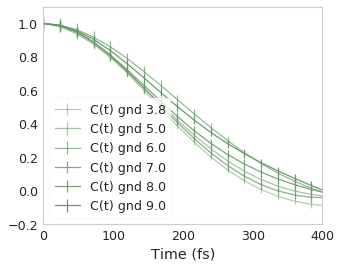

In [11]:
# C(t) gnd eqb at the 3 solvent env
plt.figure(figsize=(5,4))
plt.errorbar(gnd38[::6,0], gnd38[::6,1], yerr=gnd38[::6,2], color=(0.4, 0.6, 0.4, 0.5), label='C(t) gnd 3.8')
#plt.errorbar(gnd40[::6,0], gnd40[::6,1], yerr=gnd40[::6,2], color='C1', label='C(t) gnd 4.0')
#plt.errorbar(gnd45[::6,0], gnd45[::6,1], yerr=gnd45[::6,2], color='C1', label='C(t) gnd 4.5')
plt.errorbar(gnd50[::6,0], gnd50[::6,1], yerr=gnd50[::6,2], color=(0.4, 0.6, 0.4, 0.6), label='C(t) gnd 5.0')
#plt.errorbar(gnd55[::6,0], gnd55[::6,1], yerr=gnd55[::6,2], color='C1', label='C(t) gnd 5.5')
plt.errorbar(gnd60[::6,0], gnd60[::6,1], yerr=gnd60[::6,2], color=(0.4, 0.6, 0.4, 0.7), label='C(t) gnd 6.0')
#plt.errorbar(gnd65[::6,0], gnd65[::6,1], yerr=gnd65[::6,2], color='C1', label='C(t) gnd 6.5')
plt.errorbar(gnd70[::6,0], gnd70[::6,1], yerr=gnd70[::6,2], color=(0.4, 0.6, 0.4, 0.8), label='C(t) gnd 7.0')
#plt.errorbar(gnd75[::6,0], gnd75[::6,1], yerr=gnd75[::6,2], color='C1', label='C(t) gnd 7.5')
plt.errorbar(gnd80[::6,0], gnd80[::6,1], yerr=gnd80[::6,2], color=(0.4, 0.6, 0.4, 0.9), label='C(t) gnd 8.0')
#plt.errorbar(gnd85[::6,0], gnd85[::6,1], yerr=gnd85[::6,2], color='C1', label='C(t) gnd 8.5')
plt.errorbar(gnd90[::6,0], gnd90[::6,1], yerr=gnd90[::6,2], color=(0.4, 0.6, 0.4, 1.0), label='C(t) gnd 9.0')
plt.xlim([0,400])
plt.xlabel('Time (fs)')
plt.ylim([-0.2,1.1])
plt.legend(loc=3)
plt.grid(False)

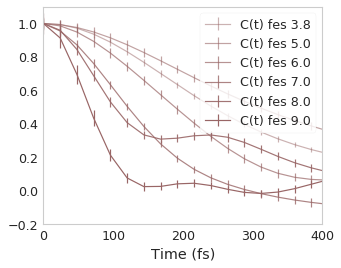

In [12]:
# C(t) fes eqb at the 3 solvent env
plt.figure(figsize=(5,4))
plt.errorbar(fes38[::6,0], fes38[::6,1], yerr=fes38[::6,2], color=(0.6, 0.4, 0.4, 0.5), label='C(t) fes 3.8')
#plt.errorbar(fes40[::6,0], fes40[::6,1], yerr=fes40[::6,2], color='C1', label='C(t) fes 4.0')
#plt.errorbar(fes45[::6,0], fes45[::6,1], yerr=fes45[::6,2], color='C1', label='C(t) fes 4.5')
plt.errorbar(fes50[::6,0], fes50[::6,1], yerr=fes50[::6,2], color=(0.6, 0.4, 0.4, 0.6), label='C(t) fes 5.0')
#plt.errorbar(fes55[::6,0], fes55[::6,1], yerr=fes55[::6,2], color='C1', label='C(t) fes 5.5')
plt.errorbar(fes60[::6,0], fes60[::6,1], yerr=fes60[::6,2], color=(0.6, 0.4, 0.4, 0.7), label='C(t) fes 6.0')
#plt.errorbar(fes65[::6,0], fes65[::6,1], yerr=fes65[::6,2], color='C1', label='C(t) fes 6.5')
plt.errorbar(fes70[::6,0], fes70[::6,1], yerr=fes70[::6,2], color=(0.6, 0.4, 0.4, 0.8), label='C(t) fes 7.0')
#plt.errorbar(fes75[::6,0], fes75[::6,1], yerr=fes75[::6,2], color='C1', label='C(t) fes 7.5')
plt.errorbar(fes80[::6,0], fes80[::6,1], yerr=fes80[::6,2], color=(0.6, 0.4, 0.4, 0.9), label='C(t) fes 8.0')
#plt.errorbar(fes85[::6,0], fes85[::6,1], yerr=fes85[::6,2], color='C1', label='C(t) fes 8.5')
plt.errorbar(fes90[::6,0], fes90[::6,1], yerr=fes90[::6,2], color=(0.6, 0.4, 0.4, 1.0), label='C(t) fes 9.0')
plt.xlim([0,400])
plt.xlabel('Time (fs)')
plt.ylim([-0.2,1.1])
plt.legend(loc=1)
plt.grid(False)

In [13]:
stitched_gnd = np.array(list(gnd38[:18,1])+
                    list(gnd50[18:27,1]-gnd50[18,1]+gnd38[18,1])+
                    list(gnd60[27:42,1]-gnd60[27,1]+gnd38[18,1]-gnd50[18,1]+gnd50[27,1])+
                    list(gnd70[42:63,1]-gnd70[42,1]+gnd38[18,1]-gnd50[18,1]+gnd50[27,1]-gnd60[27,1]+gnd60[42,1])+
                    list(gnd80[63:,1]-gnd80[63,1]+gnd38[18,1]-gnd50[18,1]+gnd50[27,1]-gnd60[27,1]+gnd60[42,1]-gnd70[42,1]+gnd70[63,1]))
stitched_fes = np.array(list(fes38[:18,1])+
                    list(fes50[18:27,1]-fes50[18,1]+fes38[18,1])+
                    list(fes60[27:42,1]-fes60[27,1]+fes38[18,1]-fes50[18,1]+fes50[27,1])+
                    list(fes70[42:63,1]-fes70[42,1]+fes38[18,1]-fes50[18,1]+fes50[27,1]-fes60[27,1]+fes60[42,1])+
                    list(fes80[63:,1]-fes80[63,1]+fes38[18,1]-fes50[18,1]+fes50[27,1]-fes60[27,1]+fes60[42,1]-fes70[42,1]+fes70[63,1]))

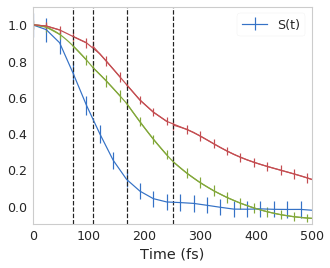

In [14]:
# S(t) with C(t) stitched together according to avg bond distance
plt.figure(figsize=(5,4))
plt.errorbar(S_t[::6,0], S_t[::6,1], yerr=S_t[::6,2], color='C0', label='S(t)')
plt.errorbar(gnd38[:18:6,0], gnd38[:18:6,1], yerr=gnd38[:18:6,2], color='C1')
plt.errorbar(gnd50[18:27:6,0], gnd50[18:27:6,1]-gnd50[18,1]+gnd38[18,1], yerr=gnd50[18:27:6,2], color='C1')
plt.errorbar(gnd60[27:42:6,0], gnd60[27:42:6,1]-gnd60[27,1]+gnd38[18,1]-gnd50[18,1]+gnd50[27,1], yerr=gnd60[27:42:6,2], color='C1')
plt.errorbar(gnd70[42:63:6,0], gnd70[42:63:6,1]-gnd70[42,1]+gnd38[18,1]-gnd50[18,1]+gnd50[27,1]-gnd60[27,1]+gnd60[42,1], yerr=gnd70[42:63:6,2], color='C1')
plt.errorbar(gnd80[63::6,0], gnd80[63::6,1]-gnd80[63,1]+gnd38[18,1]-gnd50[18,1]+gnd50[27,1]-gnd60[27,1]+gnd60[42,1]-gnd70[42,1]+gnd70[63,1], yerr=gnd80[63::6,2], color='C1')
plt.plot(gnd80[:,0], stitched_gnd[:], color='C1')
plt.errorbar(fes38[:18:6,0], fes38[:18:6,1], yerr=fes38[:18:6,2], color='C2')
plt.errorbar(fes50[18:27:6,0], fes50[18:27:6,1]-fes50[18,1]+fes38[18,1], yerr=fes50[18:27:6,2], color='C2')
plt.errorbar(fes60[27:42:6,0], fes60[27:42:6,1]-fes60[27,1]+fes38[18,1]-fes50[18,1]+fes50[27,1], yerr=fes60[27:42:6,2], color='C2')
plt.errorbar(fes70[42:63:6,0], fes70[42:63:6,1]-fes70[42,1]+fes38[18,1]-fes50[18,1]+fes50[27,1]-fes60[27,1]+fes60[42,1], yerr=fes70[42:63:6,2], color='C2')
plt.errorbar(fes80[63::6,0], fes80[63::6,1]-fes80[63,1]+fes38[18,1]-fes50[18,1]+fes50[27,1]-fes60[27,1]+fes60[42,1]-fes70[42,1]+fes70[63,1], yerr=fes80[63::6,2], color='C2')
plt.plot(fes80[::6,0], stitched_fes[::6], color='C2')

plt.axvline(x=72, color='k', linestyle='--')
plt.axvline(x=108, color='k', linestyle='--')
plt.axvline(x=168, color='k', linestyle='--')
plt.axvline(x=252, color='k', linestyle='--')

# plt.plot(np.array(6*[4*18]), np.arange(0,1.2,0.2), 'k^')
# plt.plot(np.array(6*[4*27]), np.arange(0,1.2,0.2), 'k^')
# plt.plot(np.array(6*[4*42]), np.arange(0,1.2,0.2), 'k^')
# plt.plot(np.array(6*[4*63]), np.arange(0,1.2,0.2), 'k^')

plt.xlim([0,500])
plt.xlabel('Time (fs)')
#plt.ylim([0.4,1.0])
plt.ylim([-0.1,1.1])
plt.legend(loc=1)
plt.grid(False)

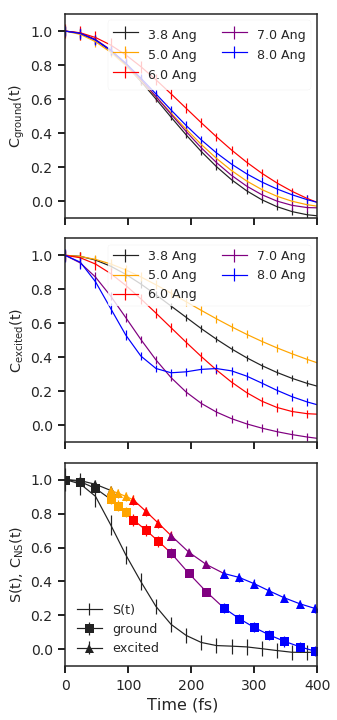

In [66]:
# Putting together for publication as 3-panel figure
fig, ((ax1, ax2, ax3)) = plt.subplots(3, 1, sharex=True, figsize=(5,12))
fig.subplots_adjust(hspace=0.1, wspace=0.0)
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams.update({'font.size': 16})
plt.gcf().subplots_adjust(left=0.2)

# C(t) gnd eqb at the 3 solvent env
a1_p1 = ax1.errorbar(gnd38[::6,0], gnd38[::6,1], yerr=gnd38[::6,2], color='k', label='3.8 Ang')
a1_p2 = ax1.errorbar(gnd50[::6,0], gnd50[::6,1], yerr=gnd50[::6,2], color='orange', label='5.0 Ang')
a1_p3 = ax1.errorbar(gnd60[::6,0], gnd60[::6,1], yerr=gnd60[::6,2], color='red', label='6.0 Ang')
a1_p4 = ax1.errorbar(gnd70[::6,0], gnd70[::6,1], yerr=gnd70[::6,2], color='purple', label='7.0 Ang')
a1_p5 = ax1.errorbar(gnd80[::6,0], gnd80[::6,1], yerr=gnd80[::6,2], color='blue', label='8.0 Ang')
#a1_p6 = ax1.errorbar(gnd90[::6,0], gnd90[::6,1], yerr=gnd90[::6,2], color='green', label='9.0 Ang')

ax1.set_ylim([-0.1,1.1])
# a1_l1 = ax1.legend([a1_p1, a1_p2, a1_p3], loc=3)
# a1_l2 = ax1.legend([a1_p4, a1_p5, a1_p6], loc=1)
# plt.gca().add_artist(a1_l1)
ax1.set_ylabel('C$_\mathregular{ground}$(t)')
ax1.legend(loc=1, ncol=2, handleheight=2.0, labelspacing=0.025)
ax1.grid(False)

# C(t) fes eqb at the 3 solvent env
ax2.errorbar(fes38[::6,0], fes38[::6,1], yerr=fes38[::6,2], color='k', label='3.8 Ang')
ax2.errorbar(fes50[::6,0], fes50[::6,1], yerr=fes50[::6,2], color='orange', label='5.0 Ang')
ax2.errorbar(fes60[::6,0], fes60[::6,1], yerr=fes60[::6,2], color='red', label='6.0 Ang')
ax2.errorbar(fes70[::6,0], fes70[::6,1], yerr=fes70[::6,2], color='purple', label='7.0 Ang')
ax2.errorbar(fes80[::6,0], fes80[::6,1], yerr=fes80[::6,2], color='blue', label='8.0 Ang')
#ax2.errorbar(fes90[::6,0], fes90[::6,1], yerr=fes90[::6,2], color='green', label='9.0 Ang')

ax2.set_ylim([-0.1,1.1])
ax2.set_ylabel('C$_\mathregular{excited}$(t)')
ax2.legend(loc=1, ncol=2)
ax2.grid(False)

# S(t) with C(t) stitched together according to avg bond distance
ax3.errorbar(S_t[::6,0], S_t[::6,1], yerr=S_t[::6,2], color='k', label='S(t)')
ax3.errorbar(gnd38[:19:6,0], gnd38[:19:6,1], yerr=gnd38[:19:6,2], color='k', label='ground', marker='s', ms=9)
ax3.errorbar(gnd50[18:28:3,0], gnd50[18:28:3,1]-gnd50[18,1]+gnd38[18,1], yerr=gnd50[18:28:3,2], color='orange', marker='s', ms=9)
ax3.errorbar(gnd60[27:43:5,0], gnd60[27:43:5,1]-gnd60[27,1]+gnd38[18,1]-gnd50[18,1]+gnd50[27,1], yerr=gnd60[27:43:5,2], color='red', marker='s', ms=9)
ax3.errorbar(gnd70[42:64:7,0], gnd70[42:64:7,1]-gnd70[42,1]+gnd38[18,1]-gnd50[18,1]+gnd50[27,1]-gnd60[27,1]+gnd60[42,1], yerr=gnd70[42:64:7,2], color='purple', marker='s', ms=9)
ax3.errorbar(gnd80[63::6,0], gnd80[63::6,1]-gnd80[63,1]+gnd38[18,1]-gnd50[18,1]+gnd50[27,1]-gnd60[27,1]+gnd60[42,1]-gnd70[42,1]+gnd70[63,1], yerr=gnd80[63::6,2], color='blue', marker='s', ms=9)
#ax3.plot(gnd80[:,0], stitched_gnd[:], color='C1')
ax3.errorbar(fes38[:19:6,0], fes38[:19:6,1], yerr=fes38[:19:6,2], color='k', label='excited', marker='^', ms=9)
ax3.errorbar(fes50[18:28:3,0], fes50[18:28:3,1]-fes50[18,1]+fes38[18,1], yerr=fes50[18:28:3,2], color='orange', marker='^', ms=9)
ax3.errorbar(fes60[27:43:5,0], fes60[27:43:5,1]-fes60[27,1]+fes38[18,1]-fes50[18,1]+fes50[27,1], yerr=fes60[27:43:5,2], color='red', marker='^', ms=9)
ax3.errorbar(fes70[42:64:7,0], fes70[42:64:7,1]-fes70[42,1]+fes38[18,1]-fes50[18,1]+fes50[27,1]-fes60[27,1]+fes60[42,1], yerr=fes70[42:64:7,2], color='purple', marker='^', ms=9)
ax3.errorbar(fes80[63::6,0], fes80[63::6,1]-fes80[63,1]+fes38[18,1]-fes50[18,1]+fes50[27,1]-fes60[27,1]+fes60[42,1]-fes70[42,1]+fes70[63,1], yerr=fes80[63::6,2], color='blue', marker='^', ms=9)
#ax3.plot(fes80[::6,0], stitched_fes[::6], color='C2')

ax3.set_xlim([0,400])
ax3.set_ylim([-0.1,1.1])
ax3.set_ylabel('S(t), C$_\mathregular{NS}$(t)')
ax3.legend(loc=3, framealpha=0.0)
ax3.grid(False)

fig.text(0.525, 0.08, 'Time (fs)', ha='center', va='center', fontname='sans-serif', size=16)

ax1.tick_params(which='major', length=7, width=2)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax2.tick_params(which='major', length=7, width=2)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax3.tick_params(which='major', length=7, width=2)
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)

ax1.spines['top'].set_linewidth(1.5)
ax1.spines['top'].set_color('k')
ax1.spines['bottom'].set_linewidth(1.5)
ax1.spines['bottom'].set_color('k')
ax1.spines['left'].set_linewidth(1.5)
ax1.spines['left'].set_color('k')
ax1.spines['right'].set_linewidth(1.5)
ax1.spines['right'].set_color('k')
ax2.spines['top'].set_linewidth(1.5)
ax2.spines['top'].set_color('k')
ax2.spines['bottom'].set_linewidth(1.5)
ax2.spines['bottom'].set_color('k')
ax2.spines['left'].set_linewidth(1.5)
ax2.spines['left'].set_color('k')
ax2.spines['right'].set_linewidth(1.5)
ax2.spines['right'].set_color('k')
ax3.spines['top'].set_linewidth(1.5)
ax3.spines['top'].set_color('k')
ax3.spines['bottom'].set_linewidth(1.5)
ax3.spines['bottom'].set_color('k')
ax3.spines['left'].set_linewidth(1.5)
ax3.spines['left'].set_color('k')
ax3.spines['right'].set_linewidth(1.5)
ax3.spines['right'].set_color('k')

#plt.tight_layout()
plt.savefig('TCFs.eps', format='eps')

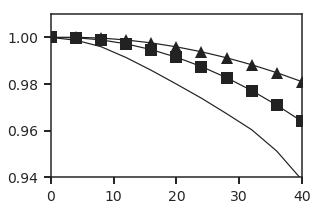

In [71]:
# inset
fig, axs = plt.subplots(1,1,figsize=(4.5,3))
plt.rcParams.update({'font.size': 16})

axs.plot(S_t[:,0], S_t[:,1], color='k')
axs.plot(gnd38[:19,0], gnd38[:19,1], color='k', marker='s', ms=12)
axs.plot(fes38[:19,0], fes38[:19,1], color='k', marker='^', ms=12)

axs.set_ylim([0.94,1.01])
axs.set_yticks(np.arange(0.94, 1.0, 0.02))
axs.set_xlim([0,40])
axs.set_xticks(np.arange(0,50,10))

axs.grid(False)
axs.tick_params(which='major', length=7, width=2)
axs.tick_params(axis='x', labelsize=14)
axs.tick_params(axis='y', labelsize=14)

axs.spines['top'].set_linewidth(1.5)
axs.spines['top'].set_color('k')
axs.spines['bottom'].set_linewidth(1.5)
axs.spines['bottom'].set_color('k')
axs.spines['left'].set_linewidth(1.5)
axs.spines['left'].set_color('k')
axs.spines['right'].set_linewidth(1.5)
axs.spines['right'].set_color('k')

plt.tight_layout
plt.savefig('TCFs_inset.eps', format='eps')

2501.0
1501.0
1501.0
1501.0


(0, 1500)

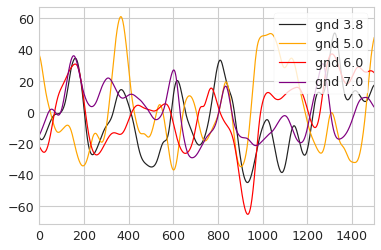

In [45]:
# gnd fluctuations
a = '3.8'
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/rigid/'+a+'/'
eigvals_gnd = lib.readEigval(my_dir, nstates=2)[500:]
bond_dist_gnd = np.loadtxt(my_dir+'/bondumb2.out')[500:]
gap_gnd = eigvals_gnd[:,2] - eigvals_gnd[:,1] - np.interp(bond_dist_gnd[:,1], gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])
gap_gnd -= np.average(gap_gnd)

gap_distr = genDistr(gap_gnd, spacing=0.01)
plt.plot(gap_gnd/np.average(gap_gnd*gap_gnd), color='k', label='gnd 3.8')

a = '5.0'
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/rigid/'+a+'/'
eigvals_gnd = lib.readEigval(my_dir, nstates=2)[500:]
bond_dist_gnd = np.loadtxt(my_dir+'/bondumb2.out')[500:]
gap_gnd = eigvals_gnd[:,2] - eigvals_gnd[:,1] - np.interp(bond_dist_gnd[:,1], gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])
gap_gnd -= np.average(gap_gnd)

gap_distr = genDistr(gap_gnd, spacing=0.01)
plt.plot(gap_gnd/np.average(gap_gnd*gap_gnd), color='orange', label='gnd 5.0')

a = '6.0'
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/rigid/'+a+'/'
eigvals_gnd = lib.readEigval(my_dir, nstates=2)[500:]
bond_dist_gnd = np.loadtxt(my_dir+'/bondumb2.out')[500:]
gap_gnd = eigvals_gnd[:,2] - eigvals_gnd[:,1] - np.interp(bond_dist_gnd[:,1], gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])
gap_gnd -= np.average(gap_gnd)

gap_distr = genDistr(gap_gnd, spacing=0.01)
plt.plot(gap_gnd/np.average(gap_gnd*gap_gnd), color='red', label='gnd 6.0')

a = '7.0'
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/rigid/'+a+'/'
eigvals_gnd = lib.readEigval(my_dir, nstates=2)[500:]
bond_dist_gnd = np.loadtxt(my_dir+'/bondumb2.out')[500:]
gap_gnd = eigvals_gnd[:,2] - eigvals_gnd[:,1] - np.interp(bond_dist_gnd[:,1], gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])
gap_gnd -= np.average(gap_gnd)

gap_distr = genDistr(gap_gnd, spacing=0.01)
plt.plot(gap_gnd/np.average(gap_gnd*gap_gnd), color='purple', label='gnd 7.0')

# a = '8.0'
# my_dir = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/rigid/'+a+'/'
# eigvals_gnd = lib.readEigval(my_dir, nstates=2)[500:]
# bond_dist_gnd = np.loadtxt(my_dir+'/bondumb2.out')[500:]
# gap_gnd = eigvals_gnd[:,2] - eigvals_gnd[:,1] - np.interp(bond_dist_gnd[:,1], gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])
# gap_gnd -= np.average(gap_gnd)

# gap_distr = genDistr(gap_gnd, spacing=0.01)
# plt.plot(gap_gnd, color='blue', label='gnd 8.0')

plt.legend(loc=1)
plt.xlim([0,1500])